In [ ]:
# Transformers installation
! pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset
from datasets import Dataset, Features, ClassLabel, Sequence, Value

def process_data(file):
      f = open(file)
      data = []
      sentences = []
      labels = []
      sentence = []
      label= []
      for line in f:
                  l=line.split('\t')
                  if len(l)==0 or l[0]=="\n" or l[0]=="  \n":
                      if len(sentence) > 0:
                          #data.append((sentence,label))
                          sentences.append(sentence)
                          labels.append(label)
                          sentence = []
                          label = []
                      continue

                  sentence.append(l[0])
                  if l[1].strip() == 'c':
                    label.append(1)
                  else:
                    label.append(0)

      if len(sentence) >0:
                  print("printing data value:", sentence, label)
                  #data.append((sentence,label))
                  sentences.append(sentence)
                  labels.append(label)
                  sentence = []
                  label = []
      
      return {'tokens': sentences, 'ner_tags': labels}


training_data_dict = process_data("train.tsv")
# training_dataset = Dataset.from_dict(training_data_dict)
testing_data_dict = process_data("dev.tsv")
testing_data_dict_1 = process_data("test.tsv")
features = Features({'tokens': Sequence(feature=Value(dtype='string', id=None)), 'ner_tags': Sequence(feature=ClassLabel(names=['i', 'c'], id=None), length=-1, id=None)})

my_dataset = Dataset.from_dict({
    'tokens': training_data_dict['tokens'],
    'ner_tags': training_data_dict['ner_tags']
}, features=features)

test_dataset = Dataset.from_dict({
    'tokens': testing_data_dict['tokens'],
    'ner_tags': testing_data_dict['ner_tags']
}, features=features)

test_dataset_1 = Dataset.from_dict({
    'tokens': testing_data_dict_1['tokens'],
    'ner_tags': testing_data_dict_1['ner_tags']
}, features=features)

print("first training example:", my_dataset["tokens"][0])


first training example: ['Dear', 'Sir', 'or', 'Madam', ',']


In [ ]:
label_list = my_dataset.features[f"ner_tags"].feature.names
label_list

['i', 'c']

In [ ]:
from transformers import GPT2Tokenizer
from transformers import GPT2Config, GPT2Model, TFBertTokenizer, BertModel
from transformers import AutoTokenizer, BertForTokenClassification, BertConfig

# Initializing a BertConfig configuration
configuration = BertConfig()

model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-cased-finetuned-conll03-english")
tokenizer.add_special_tokens({'eos_token': '[EOS]'})
tokenizer.add_special_tokens({'pad_token': '[PAD]'})


0

In [ ]:
example = my_dataset["tokens"][0]
print("example:", example)
tokenized_input = tokenizer(example,is_split_into_words=True)
print(len(tokenized_input["input_ids"]))
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

example: ['Dear', 'Sir', 'or', 'Madam', ',']
8


['[CLS]', 'Dear', 'Sir', 'or', 'Mad', '##am', ',', '[SEP]']

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_train_data = my_dataset.map(tokenize_and_align_labels, batched=True)

tokenized_test_data = test_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_test_data_1 = test_dataset_1.map(tokenize_and_align_labels, batched=True)
print(tokenized_test_data_1['labels'][0])

Map:   0%|          | 0/28731 [00:00<?, ? examples/s]

Map:   0%|          | 0/2222 [00:00<?, ? examples/s]

Map:   0%|          | 0/2720 [00:00<?, ? examples/s]

[-100, 1, 1, 1, -100]


In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
print(tokenizer)

BertTokenizerFast(name_or_path='dbmdz/bert-base-cased-finetuned-conll03-english', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '[EOS]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [ ]:
import numpy as np

labels = [label_list[i] for i in my_dataset[f"ner_tags"][0]]
print(labels)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

def compute_metrics(p):
    predictions, labels = p
    
    print("labels.shape", labels.shape)
    print("labels", labels)
    predictions = np.argmax(predictions, axis=2)
    print("predictions.shape", predictions.shape)

    predictions_flat = predictions.flatten()
    labels_flat = labels.flatten()
    new_labels = []
    new_predictions = []
    for i in range(len(labels_flat)):
      if(labels_flat[i]!=-100):
        new_labels.append(labels_flat[i])
        new_predictions.append(predictions_flat[i])


    results = accuracy_score(new_labels, new_predictions)
    # print("accuracy: ", results)
    # print("precision: ",precision_score(new_labels, new_predictions,average='macro'))
    # print("recall: ",recall_score(new_labels, new_predictions,average='macro'))
    # print( "F0.5 score:", fbeta_score(new_labels, new_predictions,average='macro', beta=0.5))

    
    return {
        "precision": precision_score(new_labels, new_predictions,average='macro'),
        "recall": recall_score(new_labels, new_predictions,average='macro'),
        "f1": fbeta_score(new_labels, new_predictions,average='macro', beta=1),
        "accuracy": results,
    }

['c', 'c', 'c', 'c', 'c']


## Train

Before you start training your model, create a map of the expected ids to their labels with `id2label` and `label2id`:

In [ ]:
id2label = {
    0: "i",
    1: "c"
}
label2id = {
    "i": 0,
    "c": 1
}

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import GPT2ForTokenClassification, GPTBigCodeModel, GPTNeoForCausalLM, OpenAIGPTModel
model = BertForTokenClassification.from_pretrained("dbmdz/bert-base-cased-finetuned-conll03-english", num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-cased-finetuned-conll03-english and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install --upgrade accelerate
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
training_args = TrainingArguments(
    output_dir="bert-token-class",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

print(my_dataset)


print(test_dataset)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 28731
})
Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 2222
})


/content/bert-token-class is already a clone of https://huggingface.co/Varunreddy/bert-token-class. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.262200,0.267326,0.858369,0.657305,0.705058,0.899535
2,0.211200,0.266568,0.846418,0.687667,0.734338,0.903697
3,0.168200,0.289147,0.833607,0.711519,0.753088,0.905575
4,0.130200,0.322397,0.827916,0.713312,0.753209,0.904737
5,0.111300,0.341539,0.822220,0.721326,0.758187,0.904737


labels.shape (2222, 222)
labels [[-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 ...
 [-100    1    1 ... -100 -100 -100]
 [-100    1    0 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]]
predictions.shape (2222, 222)
labels.shape (2222, 222)
labels [[-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 ...
 [-100    1    1 ... -100 -100 -100]
 [-100    1    0 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]]
predictions.shape (2222, 222)
labels.shape (2222, 222)
labels [[-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 ...
 [-100    1    1 ... -100 -100 -100]
 [-100    1    0 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]]
predictions.shape (2222, 222)
labels.shape (2222, 222)
labels [[-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -10

TrainOutput(global_step=8980, training_loss=0.17939417569302768, metrics={'train_runtime': 1689.9212, 'train_samples_per_second': 85.007, 'train_steps_per_second': 5.314, 'total_flos': 3358201738273140.0, 'train_loss': 0.17939417569302768, 'epoch': 5.0})

In [ ]:
loss_history = trainer.state.log_history

In [ ]:

train_loss_values = []
train_loss_epochs = []
eval_loss_values = []
eval_loss_epochs = []

for log in loss_history:
  if "loss" in log:
    train_loss_values.append(log["loss"])
    train_loss_epochs.append(log["epoch"])
  if "train_loss" in log:
    train_loss_values.append(log["train_loss"])
    train_loss_epochs.append(log["epoch"])
  if "eval_loss" in log:
    eval_loss_values.append(log["eval_loss"])
    eval_loss_epochs.append(log["epoch"])

train_loss_values

[0.2852,
 0.2717,
 0.2622,
 0.2439,
 0.215,
 0.2128,
 0.2112,
 0.1745,
 0.1679,
 0.1682,
 0.1609,
 0.135,
 0.1348,
 0.1302,
 0.119,
 0.1117,
 0.1113,
 0.17939417569302768]

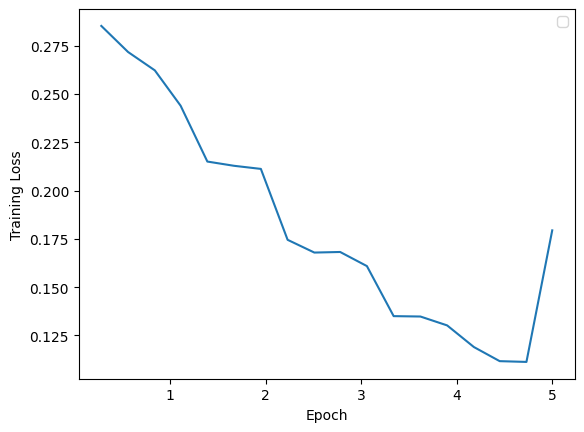

In [ ]:
# Plotting Training Loss Curve

import matplotlib.pyplot as plt
plt.plot(train_loss_epochs, train_loss_values)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

[0.26732558012008667, 0.26656803488731384, 0.2891472280025482, 0.3223969340324402, 0.34153854846954346]


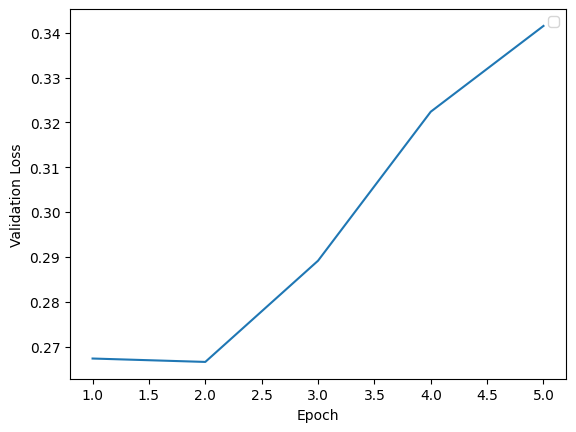

In [ ]:
# Plotting Validation Loss Curve

import matplotlib.pyplot as plt
print(eval_loss_values)
plt.plot(eval_loss_epochs, eval_loss_values)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

In [ ]:
trainer.push_to_hub()
# trainer.save_model("/")

Upload file runs/May17_18-52-33_e9bf46864e89/events.out.tfevents.1684349556.e9bf46864e89.2798.2:   0%|        …

To https://huggingface.co/Varunreddy/bert-token-class
   c926525..02f8e02  main -> main

   c926525..02f8e02  main -> main

To https://huggingface.co/Varunreddy/bert-token-class
   02f8e02..64459f4  main -> main

   02f8e02..64459f4  main -> main



'https://huggingface.co/Varunreddy/bert-token-class/commit/02f8e027de514ad35d5a715b1fe548fa6ce79f2f'

In [ ]:
from transformers import pipeline

classifier = pipeline("ner", model="Varunreddy/bert-token-class")

In [ ]:
from transformers import AutoTokenizer


In [ ]:
import numpy as np

predictions, labels, _ = trainer.predict(tokenized_test_data_1)
predictions = np.argmax(predictions, axis=2)

print(predictions[1], labels[1])
eval_labels = []
eval_preds = []
for i in range(len(labels)):
   eval_labels.extend(labels[i])
   eval_preds.extend(predictions[i])

labels.shape (2720, 111)
labels [[-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]
 ...
 [-100    1    1 ... -100 -100 -100]
 [-100    0 -100 ... -100 -100 -100]
 [-100    1    1 ... -100 -100 -100]]
predictions.shape (2720, 111)
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [-100    1    1    1    1    1    1    1    1    1    0    0    0    0
    0    0    0    0    1 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -1

In [ ]:
new_labels = []
new_predictions = []
for i in range(len(eval_labels)):
    if(eval_labels[i]!=-100):
      new_labels.append(eval_labels[i])
      new_predictions.append(eval_preds[i])

print(len(new_labels))
print(len(new_predictions))


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

results = accuracy_score(new_labels, new_predictions)
print("accuracy: ", results)
print("precision: ",precision_score(new_labels, new_predictions,average='macro'))
print("recall: ",recall_score(new_labels, new_predictions,average='macro'))
print( "F0.5 score:", fbeta_score(new_labels, new_predictions,average='macro', beta=0.5))

41477
41477
accuracy:  0.8918677821443209
precision:  0.8442859995953109
recall:  0.6878726233370157
F0.5 score: 0.7863152723823701
